In [3]:

import os
import cv2
import numpy as np
from tqdm import tqdm # this is progress bar basically
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms

from PIL import Image
from torch.autograd import Variable
import scipy.ndimage

In [4]:
REBUILD_DATA = True


In [5]:

class GoodVSCorrupt():
    IMG_SIZE = 50
    CORRUPT = "/Users/youpele/Documents/WZL/12032020/corrupt_vs_good_signal/corrupted_data/"
    GOOD = "/Users/youpele/Documents/WZL/12032020/corrupt_vs_good_signal/good_data/"
    TESTING = "PetImages/Testing"
    LABELS = {CORRUPT: 0, GOOD: 1}
    training_data = []

    cor_count = 0
    go_count = 0

    def make_training_data(self):
        for label in self.LABELS:
            print(label)
            for f in tqdm(os.listdir(label)):
                if "png" in f:
                    try:
                        path = os.path.join(label, f)
                        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
                        img = cv2.resize(img, (self.IMG_SIZE, self.IMG_SIZE))
                        self.training_data.append([np.array(img), np.eye(2)[self.LABELS[label]]])  # do something like print(np.eye(2)[1]), just makes one_hot 
                        
                        # np.eye(2)[self.LABELS[label]] 
                        # this line create one hot encode for the classes
                        # if its is cat it returns [1,0], and for dog [0,1]
                        #print(np.eye(2)[self.LABELS[label]])

                        if label == self.CORRUPT:
                            self.cor_count += 1
                        elif label == self.GOOD:
                            self.go_count += 1

                    except Exception as e:
                        pass
                        #print(label, f, str(e))

        np.random.shuffle(self.training_data)
        np.save("training_data_21_03_20.npy", self.training_data)
        print('CORRUPT:',goodvscorrupt.cor_count)
        print('GOOD:',goodvscorrupt.go_count)
        
        

In [6]:



# creating the model

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, 5)
        # input = 1
        # output = 32  convolutional features
        # kernel = 5, this is going to make a 5 by 5 kernel/window as it rolls/slides over our data to features
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        #self.conv4 = nn.Conv2d(128, 256, 5)
        # nn.Conv3d are used for scans or models

        x = torch.randn(50,50).view(-1,1,50,50)
        # 50*50 is the size of the image that we have resized earlier
        # view to flatten the image, 
        # (-1, to prepare to accept any feature we have
        # 1, a mirror of the input in the first conv1 layer
        # 50*50, same as before. )
        
        self._to_linear = None
        
        self.convs(x)

        self.fc1 = nn.Linear(self._to_linear, 512)
        # the 512 is random guessed number
        # we dont know the number that is supposed to be in self._to_linear position 
        # thus theres  a lil scrip forward that will allow us predict then use it automatically 
        self.fc2 = nn.Linear(512, 2)
        #self.fc3 = nn.Linear(1024, 2)

    def convs(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2,2))
        # 2 by 2, is the shape of the pooling
        x = F.max_pool2d(F.relu(self.conv2(x)), (2,2))
    
        
        
        

        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
        return x

    def forward(self, x):
        x = self.convs(x)
        x = x.view(-1, self._to_linear)  #we flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return F.softmax(x, dim=1)



In [8]:
# check for gpu 
        
if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")


Running on the CPU


In [13]:

net = Net().to(device)

if REBUILD_DATA:
    goodvscorrupt = GoodVSCorrupt()
    goodvscorrupt.make_training_data()

  0%|          | 2/4043 [00:00<05:12, 12.94it/s]

/Users/youpele/Documents/WZL/12032020/corrupt_vs_good_signal/corrupted_data/


  0%|          | 2/4045 [00:00<05:01, 13.41it/s]

/Users/youpele/Documents/WZL/12032020/corrupt_vs_good_signal/good_data/


100%|██████████| 4045/4045 [04:45<00:00, 14.15it/s]


CORRUPT: 4043
GOOD: 4045


In [7]:
training_data = np.load("training_data_21_03_20.npy", allow_pickle=True)
print(len(training_data))

8088


In [22]:
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

X = torch.Tensor([i[0] for i in training_data]).view(-1, 50, 50)
X = X/255.0
y = torch.Tensor([i[1] for i in training_data])


In [27]:
VAL_PCT = 0.3
val_size = int(len(X)*VAL_PCT)
print(val_size)

train_X = X[:-val_size]
train_y = y[:-val_size]

test_X = X[-val_size:]
test_y = y[-val_size:]

print(len(train_X))
print(len(test_X))

2426
5662
2426


In [28]:
# This returns the train data accuracy and loss

def fwd_pass(X, y, train=False):
    # when data pass thru here by default weight will not be updated

    if train:
        net.zero_grad()
    outputs = net(X)
    matches  = [torch.argmax(i)==torch.argmax(j) for i, j in zip(outputs, y)]
    acc = matches.count(True)/len(matches)
    loss = loss_function(outputs, y)

    if train:
        loss.backward() # backpropagation
        optimizer.step()

    return acc, loss

In [29]:
# This returns the test data accuracy and loss
    
def test(size=32):
    X, y = test_X[:size], test_y[:size]
    val_acc, val_loss = fwd_pass(X.view(-1, 1, 50, 50).to(device), y.to(device))
    return val_acc, val_loss

val_acc, val_loss = test(size=1000)
print(val_acc, val_loss)


0.494 tensor(0.2495, grad_fn=<MseLossBackward>)


In [30]:
# running the whole thing

import time

MODEL_NAME = f"model-{int(time.time())}"  # gives a dynamic model name, to just help with things getting messy over time. 
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=0.001)
loss_function = nn.MSELoss()

print(MODEL_NAME)


def train(net):
    BATCH_SIZE = 100
    EPOCHS = 3 #30

    with open("model_21_03_20.log", "a") as f:
        for epoch in range(EPOCHS):
            for i in tqdm(range(0, len(train_X), BATCH_SIZE)):
                batch_X = train_X[i:i+BATCH_SIZE].view(-1,1,50,50)
                batch_y = train_y[i:i+BATCH_SIZE]

                batch_X, batch_y = batch_X.to(device), batch_y.to(device)

                acc, loss = fwd_pass(batch_X, batch_y, train=True)

                #print(f"Acc: {round(float(acc),2)}  Loss: {round(float(loss),4)}")
                #f.write(f"{MODEL_NAME},{round(time.time(),3)},train,{round(float(acc),2)},{round(float(loss),4)}\n")
                # just to show the above working, and then get out:
                if i % 50 == 0:
                    # for every 50 steps we;ll calc val accuracy and loss
                    val_acc, val_loss = test(size=100)
                    f.write(f"{MODEL_NAME},{round(time.time(),3)},{round(float(acc),2)},{round(float(loss), 4)},{round(float(val_acc),2)},{round(float(val_loss),4)},{epoch}\n")


model-1584809972


In [31]:

train(net)



100%|██████████| 57/57 [00:57<00:00,  1.01s/it]


In [45]:

# Comparing test accu, loss vs train accu, loss
# plot this on sublime 



import matplotlib.pyplot as plt
from matplotlib import style

style.use("ggplot")

#model_name = MODEL_NAME #"model-1570499409" # grab whichever model name you want here. We could also just reference the MODEL_NAME if you're in a notebook still.

model_name = "model-1584809972" 

def create_acc_loss_graph(model_name):
    contents = open("model_21_03_20.log", "r").read().split("\n")

    times = []
    accuracies = []
    losses = []

    val_accs = []
    val_losses = []

    for c in contents:
        if model_name in c:
            name, timestamp, acc, loss, val_acc, val_loss, none = c.split(",")

            times.append(float(timestamp))
            accuracies.append(float(acc))
            losses.append(float(loss))

            val_accs.append(float(val_acc))
            val_losses.append(float(val_loss))


    fig = plt.figure()

    ax1 = plt.subplot2grid((2,1), (0,0)) #(2,1) 2 by 1 grid, (0,0) this graph will start at the x=0,y=0 mark
    ax2 = plt.subplot2grid((2,1), (1,0), sharex=ax1) # (1,0) start at 1,0 mark, and will share x axis with  graph ax1


    ax1.plot(times, accuracies, label="acc")
    ax1.plot(times, val_accs, label="val_acc")
    ax1.legend(loc=2) # location 2
    ax2.plot(times,losses, label="loss")
    ax2.plot(times,val_losses, label="val_loss")
    ax2.legend(loc=2)
    plt.savefig("model_21_03_20.png", dpi =800)
    #plt.show()


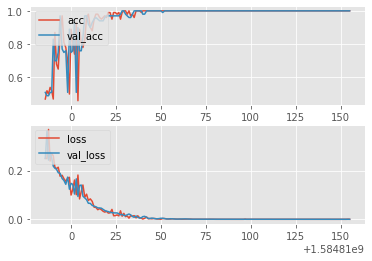

In [14]:
# saving a model

torch.save(net.state_dict(),"/Users/youpele/Documents/WZL/12032020/another1.pth")

In [7]:
# loading a model

model = Net()
#model.load_state_dict("/Users/youpele/Documents/WZL/12032020/another1.pth")


model.load_state_dict(torch.load("/Users/youpele/Documents/WZL/12032020/another1.pth", map_location='cpu'))
#model = torch.load("/Users/youpele/Documents/WZL/12032020/another1.pth", map_location='cpu'))

<All keys matched successfully>

In [105]:
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

# Prediction 

In [8]:

import shutil
import torch
from torchvision import datasets, models, transforms
import os


In [9]:

def predict_signal(model_path, containing_folder, image_folder, image_index = 1):
    
    # Setting up folders
    folders = ['predicted_corrupt', 'predicted_good' ]
    
    for folder in folders:
        new_folder = containing_folder + folder
        if not os.path.exists(new_folder):
            os.makedirs(new_folder)
            print("Folder " , new_folder ,  " has been created ")
        else: 
            print("Directory " , new_folder ,  " already exists")
            
            
    
    # Prediction and copying predicted image to its respective folder
    
    model = Net()
    model.load_state_dict(torch.load(model_path, map_location='cpu'))
    
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    pred_s = []
    tf = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
    
    image_datasets = datasets.ImageFolder(containing_folder, tf)
    inputs = image_datasets[image_index]
    print (inputs[1])
    with torch.no_grad():
        inputs = inputs[0][None, ...].to(device)
        outputs = model(inputs)
        pred_s.append(outputs.argmax(dim=1).cpu().item())
    print(pred_s[0])
    
    
    image_folder_list = os.listdir(image_folder)
    if pred_s[0] == 0:
        print('This signal is corrupted!')
        
        shutil.copy(image_folder + image_folder_list[image_index],
                        containing_folder + folders[0] + '/' + image_folder_list[image_index])
        print('Image has been moved to', folders[0], ' folder.')
        
    elif pred_s[0] == 1:
        
        print('This signal is good!')
        shutil.copy(image_folder + image_folder_list[image_index],
                        containing_folder + folders[1] + '/' + image_folder_list[image_index])
        print('Image has been moved to', folders[1], 'folder.')
        
        
   
    

In [10]:


# multiple image prediction

containing_folder = '/Users/youpele/Documents/WZL/12032020/dataset/unused/'

image_folder = '/Users/youpele/Documents/WZL/12032020/dataset/unused/files/'

model_path = "/Users/youpele/Documents/WZL/12032020/another1.pth"


In [11]:

for image_index in range(0, len(os.listdir(image_folder))):
    
    b = predict_signal(model_path=model_path,
                              containing_folder=containing_folder,
                              image_index=image_index, 
                              image_folder=image_folder)

Directory  /Users/youpele/Documents/WZL/12032020/dataset/unused/predicted_corrupt  already exists
Directory  /Users/youpele/Documents/WZL/12032020/dataset/unused/predicted_good  already exists
0


RuntimeError: Given groups=1, weight of size 32 1 5 5, expected input[1, 3, 224, 224] to have 1 channels, but got 3 channels instead

# I always get errors here

In [3]:
from torchvision.models import squeezenet1_1


model = Net(num_classes=2)
#model = squeezenet1_1(pretrained=True)
model.eval()

NameError: name 'Net' is not defined

In [143]:
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 50)
    transformation = transforms.Compose([
        transforms.CenterCrop(50),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    
    input1 = transforms.ToPILImage()(image_tensor.float())
    
    
    


    #if torch.cuda.is_available():
        #image_tensor.cuda()

    # Turn the input into a Variable
    #input = Variable(image_tensor)
    input = Variable(input1)

    # Predict the class of the image
    output = model(input)

    index = output.data.numpy().argmax()

    return index



In [144]:
index = predict_image("/Users/youpele/Documents/WZL/12032020/dataset/unused/corrupted/R3_1_Stempel_hinten_132.png")

prediction = class_map[str(index)][1]

print("Predicted Class ", prediction)

Prediction in progress


TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

In [42]:
import cv2
import numpy as np
from PIL import Image

img = cv2.imread("/Users/youpele/Documents/WZL/12032020/dataset/unused/corrupted/R1_1_Stempel_hinten_1743.png")

# You may need to convert the color.
#img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(img)

In [46]:
pil2tensor = transforms.ToTensor()
tensor2pil = transforms.ToPILImage()

# Read the image from file. Assuming it is in the same directory.
pil_image = Image.open("/Users/youpele/Documents/WZL/12032020/dataset/unused/corrupted/R1_1_Stempel_hinten_1743.png")
rgb_image = pil2tensor(pil_image)



In [47]:
type(rgb_image)

torch.Tensor

In [78]:
#output = model(rgb_image[50,50])

In [100]:
#reshaped = rgb_image.permute(2, 0, 1).unsqueeze(0)
your_result = model(rgb_image)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight 32 1 5 5, but got 3-dimensional input of size [4, 2000, 3000] instead

In [93]:
model.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5184, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=2, bias=True)
)

In [115]:
# Import needed packages
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
import requests
import shutil
from io import open
import os
from PIL import Image
import json

In [146]:
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 50)
    transformation = transforms.Compose([
        transforms.CenterCrop(50),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))

    ])

    # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    image_tensor = image_tensor.unsqueeze_(0)
    
    input1 = transforms.ToPILImage()(image_tensor.float())
    
    
    


    #if torch.cuda.is_available():
        #image_tensor.cuda()

    # Turn the input into a Variable
    #input = Variable(image_tensor)
    input = Variable(input1)

    # Predict the class of the image
    output = model(input)

    index = output.data.numpy().argmax()

    return index



In [170]:
def predict_image(image_path):
    print("Prediction in progress")
    image = Image.open(image_path)

    # Define transformations for the image, should (note that imagenet models are trained with image size 50)
    transformation = transforms.Compose([
        transforms.CenterCrop(50),
        transforms.ToTensor(),
        transforms.Grayscale(num_output_channels=1),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),

    ])

        # Preprocess the image
    image_tensor = transformation(image).float()

    # Add an extra batch dimension since pytorch treats all images as batches
    #image_tensor = image_tensor.unsqueeze_(0)
    
    image_PIL =transforms.ToPILImage()
    
    

    if torch.cuda.is_available():
        image_tensor.cuda()

    # Turn the input into a Variable
    input = Variable(image_PIL(image_tensor))

    # Predict the class of the image
    output = model(input)

    index = output.data.numpy().argmax()

    return index
    
    


In [171]:
input1 = predict_image("/Users/youpele/Documents/WZL/12032020/dataset/unused/corrupted/R3_1_Stempel_hinten_132.png")

Prediction in progress


TypeError: img should be PIL Image. Got <class 'torch.Tensor'>

In [173]:
img_tensor = transforms.ToTensor()
img_pil = transforms.ToPILImage()

In [177]:
import numpy as np
array = np.asarray("/Users/youpele/Documents/WZL/12032020/dataset/unused/corrupted/R3_1_Stempel_hinten_132.png")
type(array)

numpy.ndarray

In [179]:

a = img_pil(array)

ValueError: pic should be 2/3 dimensional. Got 0 dimensions.